In [1]:
import pandas as pd
import numpy as np
import datetime
import calendar
import timeit
import datetime as dt
import re
from math import exp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
start_time = datetime.datetime.now()

In [2]:
data = pd.read_csv('card transactions.csv')
data.shape

(96753, 10)

In [3]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0


In [4]:
data.dropna(how='all', axis=1, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96753 non-null  int64         
 1   Cardnum            96753 non-null  int64         
 2   Date               96753 non-null  datetime64[ns]
 3   Merchnum           93378 non-null  object        
 4   Merch description  96753 non-null  object        
 5   Merch state        95558 non-null  object        
 6   Merch zip          92097 non-null  float64       
 7   Transtype          96753 non-null  object        
 8   Amount             96753 non-null  float64       
 9   Fraud              96753 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 7.4+ MB


In [5]:
data = data[data['Transtype'] == 'P']
data = data[data['Amount'] <= 3000000]
data.shape

(96397, 10)

In [6]:
data.isna().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             3198
Merch description       0
Merch state          1020
Merch zip            4300
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

In [7]:
data_orig = data.copy()

## Clean and impute merchnum

In [8]:
data['Merchnum'] = data['Merchnum'].replace({'0':np.nan})

In [9]:
data['Merchnum'].isnull().sum()

3251

In [10]:
merchdes_merchnum = {}
for index, merchdes in data[data['Merch description'].notnull()][data['Merchnum'].notnull()]['Merch description'].items():
    if pd.isnull(merchdes) == True:
        continue
    elif merchdes not in merchdes_merchnum:
        merchdes_merchnum[merchdes] = data.loc[index, 'Merchnum']

In [11]:
# fill in by mapping with Merch description
data['Merchnum'] = data['Merchnum'].fillna(data['Merch description'].map(merchdes_merchnum))

In [12]:
data['Merchnum'].isnull().sum()

2094

In [13]:
# assign unknown for adjustments transactions
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [14]:
data['Merchnum'].isnull().sum()

1403

In [15]:
data.loc[data.Merchnum.isna(), 'Merch description'].unique()[:20]

array(['MONTGOMERY COLLEGE-PHONE', 'PACKAGE PLACE  THE',
       'CUBIX CORPORATION', 'SIGNAL GRAPHICS PRINTING',
       'C & M OFFICE EQUIPMENT', "TOMMY'S TRAILERS",
       'Z WORLD/RABBIT SEMICONDUC', 'IMPAC/TRI-COUNTY/FREED',
       'REPROGRPHC TECHNLGIES INC', 'STP SPECIALITY TECH',
       'VANGARD INTERNAITONAL', 'BLACKWELL SCIENCE', 'CDN ISOTOPES INC',
       'INTERACTIVE SOFTWARE S', 'H R WILLIAMS MILL SUPP',
       'ELSEVIER SCIENCE BV', 'COLORADO GARDEN SHOW',
       'PEARSON EDUCATION CANADA', 'PONTOTOC AREA VO-TECH',
       'NATIONAL BAG COMPANY'], dtype=object)

In [16]:
# 1403 NULL Merchnums with 508 unique Descriptions
data.loc[data.Merchnum.isna(), 'Merch description'].nunique()

508

### Create new Merchnums using the description field

In [17]:
# adding new merchnums
# each new unique merchnum will be max(merchnum) + 1
merchnum_create = {}
max_merchnum = pd.to_numeric(data.Merchnum, errors='coerce').max()
for merch_desc in data.loc[data.Merchnum.isna(), 'Merch description'].unique():
  merchnum_create[merch_desc] = str(int(max_merchnum + 1))
  max_merchnum += 1

In [18]:
# fill in by mapping with Merch description (newly created merchnums)
data['Merchnum'] = data['Merchnum'].fillna(data['Merch description'].map(merchnum_create))

In [19]:
for i in data.columns:
    print(i, data[i].isnull().sum())

Recnum 0
Cardnum 0
Date 0
Merchnum 0
Merch description 0
Merch state 1020
Merch zip 4300
Transtype 0
Amount 0
Fraud 0


## Clean and impute State

In [20]:
data['Merch state'].isnull().sum()

1020

In [21]:
data[(data['Merch state'].isnull()) & (data['Merch zip'].notnull())]['Merch zip'].unique()

array([9.2600e+02, 9.2900e+02, 1.4000e+03, 6.5132e+04, 8.6899e+04,
       2.3080e+04, 6.0528e+04, 9.3400e+02, 9.0200e+02, 7.3800e+02,
       9.0805e+04, 7.6302e+04, 9.0000e+00, 9.1400e+02, 6.0000e+00,
       9.5461e+04, 5.0823e+04, 2.0000e+00, 4.8700e+04, 6.8000e+02,
       1.0000e+00, 6.8100e+02, 6.2300e+02, 7.2600e+02, 9.3600e+02,
       1.2108e+04, 7.9100e+02, 9.0700e+02, 9.2200e+02, 9.2000e+02,
       3.0000e+00, 8.0100e+02, 8.0000e+00, 3.1040e+04, 3.8117e+04,
       4.1160e+04])

In [22]:
# dict for mapping
zip_state = {}
for index, zip5 in data[data['Merch zip'].notnull()]['Merch zip'].items():
    if zip5 not in zip_state:
        zip_state[zip5] = data.loc[index, 'Merch state']
        
zip_state['00926'] = 'PR'
zip_state['00929'] = 'PR'
zip_state['00934'] = 'PR'
zip_state['00902'] = 'PR'
zip_state['00738'] = 'PR'
zip_state['90805'] = 'CA'
zip_state['76302'] = 'TX'
zip_state['00914'] = 'PR'
zip_state['95461'] = 'CA'
zip_state['00680'] = 'PR'
zip_state['00623'] = 'PR'
zip_state['00726'] = 'PR'
zip_state['00936'] = 'PR'
zip_state['12108'] = 'NY'
zip_state['00791'] = 'PR'
zip_state['00907'] = 'PR'
zip_state['00922'] = 'PR'
zip_state['00920'] = 'PR'
zip_state['00801'] = 'VI'
zip_state['31040'] = 'GA'
zip_state['41160'] = 'KY'
zip_state['00681'] = 'PR'

In [23]:
merchnum_state = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_state :
        merchnum_state [merchnum] = data.loc[index, 'Merch state']

In [24]:
merchdes_state = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_state :
        merchdes_state [merchdes] = data.loc[index, 'Merch state']

In [25]:
# fill in by mapping with zip, merchnum and merch description
data['Merch state'] = data['Merch state'].fillna(data['Merch zip'].map(zip_state))
data['Merch state'] = data['Merch state'].fillna(data['Merchnum'].map(merchnum_state))
data['Merch state'] = data['Merch state'].fillna(data['Merch description'].map(merchdes_state))

In [26]:
# assign unknown for adjustments transactions
data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [27]:
data['Merch state'].isnull().sum()

346

In [28]:
# change non-US states
# might actually be useful cus fraud could be foreign transactions
# maybe put a 'foreign' tag or just leave them as is

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", 
          'VI', 'PR', np.nan, 'unknown']

for index, state in data['Merch state'].items():
    if state not in states:
        data.loc[index, 'Merch state'] = 'foreign'

In [29]:
data['Merch state'].fillna('unknown',inplace=True)

In [30]:
data['Merch state'].isnull().sum()

0

## Clean and impute zip

In [31]:
data['Merch zip'].isnull().sum()

4300

In [32]:
merchnum_zip = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_zip :
        merchnum_zip [merchnum] = data.loc[index, 'Merch zip']

In [33]:
merchdes_zip = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_zip :
        merchdes_zip [merchdes] = data.loc[index, 'Merch zip']

In [34]:
# fill in by mapping with merchnum and merch description
data['Merch zip'] = data['Merch zip'].fillna(data['Merchnum'].map(merchnum_zip))
data['Merch zip'] = data['Merch zip'].fillna(data['Merch description'].map(merchdes_zip))

In [35]:
data['Merch zip'].isnull().sum()

2658

In [36]:
# assign unknown for adjustments transactions
data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [37]:
data['Merch zip'].isnull().sum()

2658

In [38]:
temp = data[data['Merch zip'].isna()]
temp.head(50)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
51,52,5142204384,2006-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
54,55,5142146340,2006-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,23.90,0
55,56,5142260984,2006-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,19.95,0
58,59,5142204384,2006-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
59,60,5142204384,2006-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
60,61,5142204384,2006-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
61,62,5142204384,2006-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
62,63,5142253356,2006-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,27.41,0
64,65,5142204384,2006-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
65,66,5142204384,2006-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0


In [39]:
data['Merch zip'].fillna('unknown', inplace=True)
data['Merch zip'].isnull().sum()

0

In [40]:
df = data.copy()

In [41]:
data.to_csv('transactions_clean.csv')

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96397 non-null  int64         
 1   Cardnum            96397 non-null  int64         
 2   Date               96397 non-null  datetime64[ns]
 3   Merchnum           96397 non-null  object        
 4   Merch description  96397 non-null  object        
 5   Merch state        96397 non-null  object        
 6   Merch zip          96397 non-null  object        
 7   Transtype          96397 non-null  object        
 8   Amount             96397 non-null  float64       
 9   Fraud              96397 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 10.1+ MB


## I. Risk variables

In [43]:
## to be safe, check the data type of dates first
df.Date = pd.to_datetime(df.Date)
df.Date.dtypes
## all good

dtype('<M8[ns]')

In [44]:
## find the day of the week
df['Dow'] = df.Date.apply(lambda x: calendar.day_name[x.weekday()])

In [45]:
## we want to not use the oot for target encoding variables
train_test = df[df.Date < '2006-11-01']
c = 4; nmid = 20; y_avg = train_test['Fraud'].mean()
y_dow = train_test.groupby('Dow')['Fraud'].mean()
num = train_test.groupby('Dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/(1 + np.exp(-(num - nmid)/c))
df['Dow_Risk'] = df.Dow.map(y_dow_smooth)

In [46]:
y_dow=y_dow.reset_index()
cats=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y_dow['Dow']=pd.Categorical(y_dow['Dow'], categories=cats, ordered=True)
y_dow=y_dow.sort_values('Dow')
y_dow=y_dow.set_index('Dow')
y_dow

,Fraud
Dow,
Monday,0.010095
Tuesday,0.009630
Wednesday,0.008711
Thursday,0.007127
Friday,0.009788
Saturday,0.018626
Sunday,0.025994


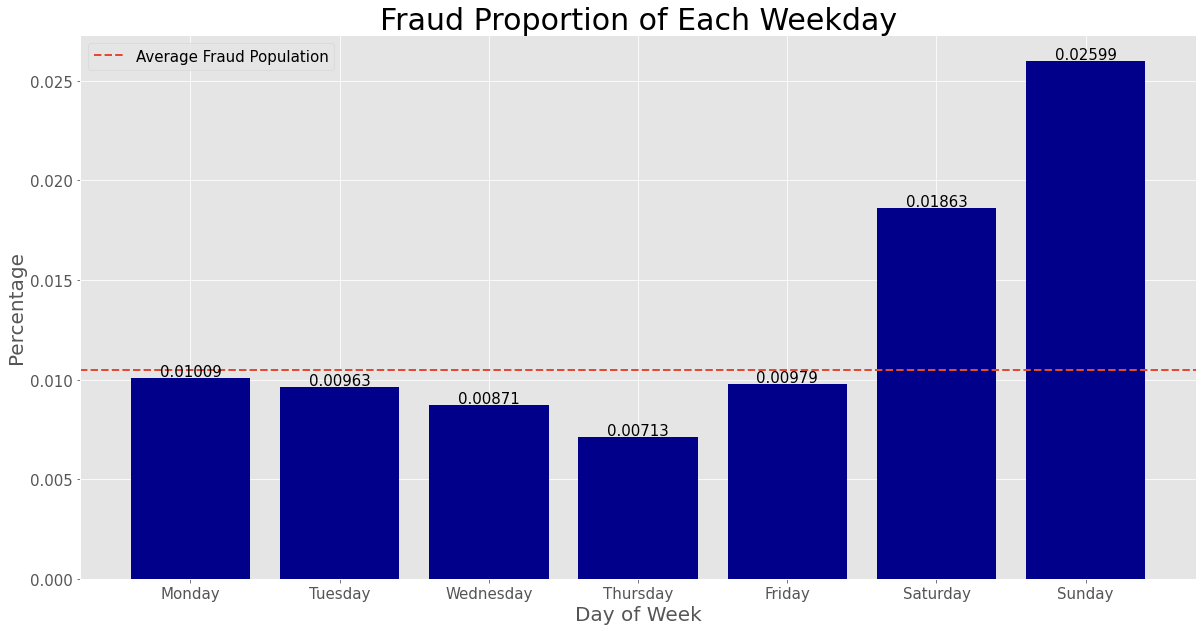

In [47]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data = y_dow, 
        x = y_dow.index, 
        height = 'Fraud',
        color = 'darkblue'
        )
#ax.set_ylim(bottom = 0.013)
ax.axhline(y = y_avg, ls = '--', lw = 2, label="Average Fraud Population")

for i, v in enumerate(y_dow.index):
    ax.text(v,y_dow.loc[v,'Fraud']+0.0001,round(y_dow.loc[v,'Fraud'],5),horizontalalignment='center',fontsize=15)

plt.legend(['Average Fraud Population'], fontsize=15)
plt.xlabel("Day of Week",fontsize=20)
plt.ylabel("Percentage",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Fraud Proportion of Each Weekday", fontsize=30)

plt.show()

In [48]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Dow,Dow_Risk
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Sunday,0.025994
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Sunday,0.025994
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994


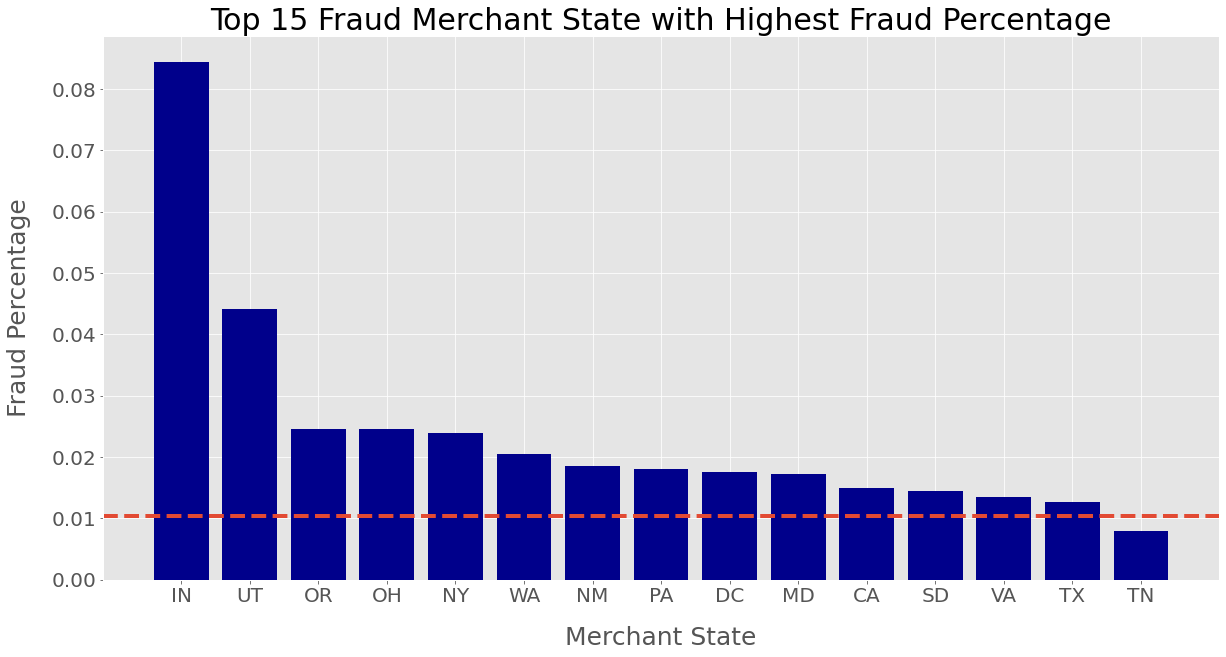

In [49]:
# statistical smoothing
c = 4
nmid = 20
y_avg = train_test['Fraud'].mean()
y_state = train_test.groupby('Merch state')['Fraud'].mean()
num = train_test.groupby('Merch state').size()
y_state_smooth = y_avg + (y_state - y_avg)/(1 + np.exp(-(num-nmid)/c))
df['state_risk'] = df['Merch state'].map(y_state_smooth)
top15_states = pd.DataFrame(y_state.sort_values(ascending=False).head(15))
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data=top15_states, x=top15_states.index, height='Fraud', color='darkblue')

plt.title('Top 15 Fraud Merchant State with Highest Fraud Percentage', fontsize=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Merchant State',fontsize=25, labelpad=20)
plt.ylabel('Fraud Percentage',fontsize=25, labelpad=20)

ax.axhline(y=y_avg, lw = 4, ls='--')
plt.show()

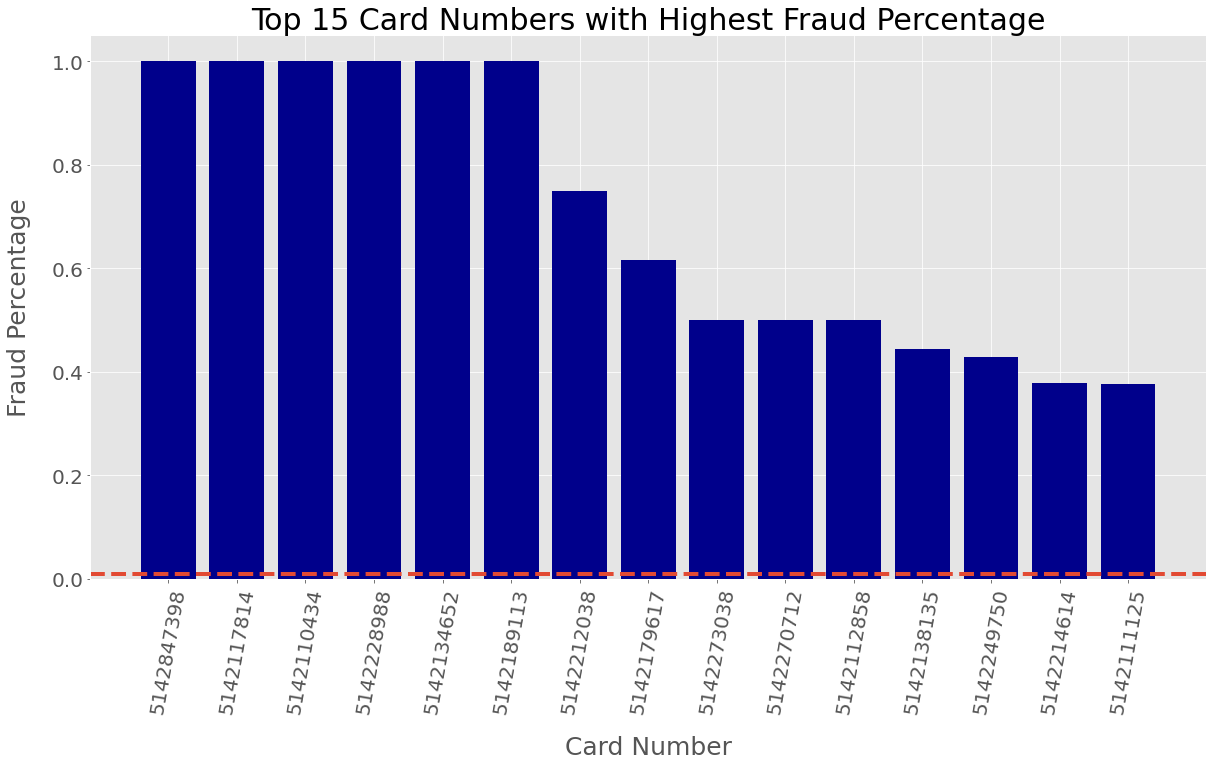

In [50]:
# statistical smoothing
c = 4
nmid = 20
y_avg = train_test['Fraud'].mean()
y_cardnum = train_test.groupby('Cardnum')['Fraud'].mean()
num = train_test.groupby('Cardnum').size()
y_cardnum_smooth = y_avg + (y_cardnum - y_avg)/(1 + np.exp(-(num-nmid)/c))

# comment this out so we don't include this variable because it overfits
# df['cardnum_risk'] = df['Cardnum'].map(y_cardnum_smooth)
top15_cardnum = pd.DataFrame(y_cardnum\
                             .sort_values(ascending=False).head(15))
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data=top15_cardnum, x=top15_cardnum.index.astype(str), height='Fraud', color='darkblue')
plt.title('Top 15 Card Numbers with Highest Fraud Percentage', fontsize=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Card Number',fontsize=25, labelpad=20)
plt.ylabel('Fraud Percentage',fontsize=25, labelpad=20)
plt.xticks(rotation = 80)

ax.axhline(y=y_avg, lw = 4, ls='--')

plt.show()

In [51]:
# statistical smoothing
c = 4
nmid = 20
y_avg = train_test['Fraud'].mean()
y_merchnum = train_test.groupby('Merchnum')['Fraud'].mean()
num = train_test.groupby('Merchnum').size()
y_merchnum_smooth = y_avg + (y_merchnum - y_avg)/(1 + np.exp(-(num-nmid)/c))

# comment this out so we don't include this variable because it overfits
# data['merchnum_risk'] = data['Merchnum'].map(y_merchnum_smooth)
top15_merchnum = pd.DataFrame(y_merchnum\
                             .sort_values(ascending=False).head(15))
top15_merchnum.head(20)

# plt.style.use('ggplot')
# fig, ax = plt.subplots(figsize=(20,10))
# plt.bar(data=top15_merchnum, x=top15_merchnum.index.astype(str), height='Fraud', color='darkblue')
# plt.title('Top 15 Merchant Numbers with Highest Fraud Percentage', fontsize=30)

# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.xlabel('Merchant Number',fontsize=25, labelpad=20)
# plt.ylabel('Fraud Percentage',fontsize=25, labelpad=20)
# plt.xticks(rotation = 80)

# ax.axhline(y=y_avg, lw = 4, ls='--')

# plt.show()

,Fraud
Merchnum,
450730006NOT0,1.000000
6006333528866,1.000000
4503738417400,1.000000
600660007477,1.000000
19908503337,1.000000
7000330100777,1.000000
8834000695423,1.000000
7593860080752,1.000000
92891948003,1.000000


## II. Other variables

### 2.1. Data types

In [52]:
df['Cardnum'] = df['Cardnum'].apply(str)
df['Merchnum'] = df['Merchnum'].apply(str)
df['Merch zip'] = df['Merch zip'].apply(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96397 non-null  int64         
 1   Cardnum            96397 non-null  object        
 2   Date               96397 non-null  datetime64[ns]
 3   Merchnum           96397 non-null  object        
 4   Merch description  96397 non-null  object        
 5   Merch state        96397 non-null  object        
 6   Merch zip          96397 non-null  object        
 7   Transtype          96397 non-null  object        
 8   Amount             96397 non-null  float64       
 9   Fraud              96397 non-null  int64         
 10  Dow                96397 non-null  object        
 11  Dow_Risk           96397 non-null  float64       
 12  state_risk         96397 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory 

In [53]:
### add leading 0 to zips
### note: there are some zips that are state abbrv. as we imputed them ealier, so pandas read the column as str

def leading_0(x):
    
    if '.0' in x:
        x = x[:-2]
        if len(x) == 5:
            return x
        else: 
            return '0'*(5-len(x)) + x
    else:
        return '0'*(5-len(x)) + x

# df['Merch zip'] = df['Merch zip'].apply(leading_0)

In [54]:
### delete white spaces in merch description
df['Merch description'] = df['Merch description'].str.replace(r'\s', '')

### 2.2. Create entities

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96397 non-null  int64         
 1   Cardnum            96397 non-null  object        
 2   Date               96397 non-null  datetime64[ns]
 3   Merchnum           96397 non-null  object        
 4   Merch description  96397 non-null  object        
 5   Merch state        96397 non-null  object        
 6   Merch zip          96397 non-null  object        
 7   Transtype          96397 non-null  object        
 8   Amount             96397 non-null  float64       
 9   Fraud              96397 non-null  int64         
 10  Dow                96397 non-null  object        
 11  Dow_Risk           96397 non-null  float64       
 12  state_risk         96397 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory 

In [56]:
df['card_merch'] = df['Cardnum'] + df['Merchnum']
df['card_zip'] = df['Cardnum'] + df['Merch zip']
df['card_state'] = df['Cardnum'] + df['Merch state']
df['merch_zip'] = df['Merchnum'] + df['Merch zip']
df['merch_state'] = df['Merchnum'] + df['Merch state']
df['state_des'] = df['Merch state'] + df['Merch description']

# these next two entities take a long time to calculate the variables for, and I don't know why
df['state_zip'] = df['Merch state'] + df['Merch zip']
df['zip3'] = df['Merch zip'].str[:3]

df['card_zip3'] = df.Cardnum + df['zip3']
df['merchnum_zip'] = df.Merchnum + df['Merch zip']
df['merchnum_zip3'] = df.Merchnum + df['zip3']

df['Card_Merchdesc'] = df['Cardnum'] + df['Merch description']
df['Card_dow'] = df['Cardnum'] + df['Dow']
df['Merchnum_desc'] = df['Merchnum'] + df['Merch description']
df['Merchnum_dow'] = df['Merchnum'] + df['Dow']
df['Merchdesc_State'] = df['Merch description'] + df['Merch state']
df['Merchdesc_Zip'] = df['Merch description'] + df['Merch zip']
df['Merchdesc_dow'] = df['Merch description'] + df['Dow']
df['Card_Merchnum_desc'] = df['Cardnum'] + df['Merchnum'] + df['Merch description']
df['Card_Merchnum_State'] = df['Cardnum'] + df['Merchnum'] + df['Merch state']
df['Card_Merchnum_Zip'] = df['Cardnum'] + df['Merchnum'] + df['Merch zip']
df['Card_Merchdesc_State'] = df['Cardnum'] + df['Merch description'] + df['Merch state']
df['Card_Merchdesc_Zip'] = df['Cardnum'] + df['Merch description'] + df['Merch zip']
df['Merchnum_desc_State'] = df['Merchnum'] + df['Merch description'] + df['Merch state']
df['Merchnum_desc_Zip'] = df['Merchnum'] + df['Merch description'] + df['Merch zip']


In [57]:
df.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'Dow',
       'Dow_Risk', 'state_risk', 'card_merch', 'card_zip', 'card_state',
       'merch_zip', 'merch_state', 'state_des', 'state_zip', 'zip3',
       'card_zip3', 'merchnum_zip', 'merchnum_zip3', 'Card_Merchdesc',
       'Card_dow', 'Merchnum_desc', 'Merchnum_dow', 'Merchdesc_State',
       'Merchdesc_Zip', 'Merchdesc_dow', 'Card_Merchnum_desc',
       'Card_Merchnum_State', 'Card_Merchnum_Zip', 'Card_Merchdesc_State',
       'Card_Merchdesc_Zip', 'Merchnum_desc_State', 'Merchnum_desc_Zip'],
      dtype='object')

In [58]:
entities = list(df.iloc[:, np.r_[1, 3, 12:len(df.columns)]].columns)

In [59]:
entities

['Cardnum',
 'Merchnum',
 'state_risk',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'state_zip',
 'zip3',
 'card_zip3',
 'merchnum_zip',
 'merchnum_zip3',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_State',
 'Merchdesc_Zip',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_State',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_State',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State',
 'Merchnum_desc_Zip']

### 2.3. Variables

In [60]:
df.Date = pd.to_datetime(df.Date)
df1 = df.copy()
final = df.copy()
df1['check_date'] = df1.Date
df1['check_record'] = df1.Recnum

## Benford's law variables

In [61]:
# split out the first digit of Amount
def first_digit(amount):
    amount=amount*100
    amount=str(amount)
    first_d=int(amount[0])
    return first_d
df1['first_digit']=df1.Amount.apply(first_digit)
df1['smallthan_3']=df1.first_digit.apply(lambda x:1 if x < 3 else 0)

In [62]:
%%time

# I think this calculates Benford's variables looking backwards only.
final['is_fedex']=final['Merch description'].str.findall(r'\bfedex\b', flags=re.IGNORECASE).apply(len)
c=3;nmid=15
for entity in ['Cardnum','Merchnum']:
  col_name=f'benford_{entity}'
  df_l=df1[['Recnum',entity]]
  df_r=df1[['check_record',entity,'smallthan_3']]
  temp=pd.merge(df_l,df_r,left_on=entity,right_on=entity)
  temp=temp[temp.check_record<=temp.Recnum]
  temp['n']=temp.groupby('Recnum')['smallthan_3'].transform('count')
  temp['n_low']=temp.groupby('Recnum')['smallthan_3'].transform('sum')
  temp['n_high']=temp.n-temp.n_low
  temp['n_low'][temp.n_low==0]=1
  temp['n_high'][temp.n_high==0]=1
  temp['R'] = 1.096*temp.n_low/temp.n_high
  temp['R_inv'] = 1/temp.R
  temp['benford']=temp[['R', 'R_inv']].max(axis=1)
  U=temp[['Recnum','benford']].groupby('Recnum')['benford'].max()
  n=temp.groupby('Recnum').size()
  t=(n-nmid)/c
  mapper=1+(U-1)/(1+np.exp(-t))
  final[col_name]= final.Recnum.map(mapper)
  final[col_name][final.is_fedex==1]=1
final.drop('is_fedex',axis=1,inplace=True)

del U,n,t

CPU times: user 18.8 s, sys: 11.6 s, total: 30.4 s
Wall time: 25.9 s


## This part is to build the Benford's law variables

In [63]:
# another way to get the first digit
bf = data.copy()
bf['amount_100'] = (bf['Amount'] * 100).astype(str)
bf['first_digit'] = bf['amount_100'].str[0]
bf['first_digit'].value_counts()

1    26603
3    18670
2    16178
4     8278
5     6955
6     6017
7     5027
8     4534
9     4135
Name: first_digit, dtype: int64

In [64]:
dropfedex = bf[bf['Merch description'].str.contains('FEDEX')]
dropfedex.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,amount_100,first_digit
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,362.0,3
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,362.0,3
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,362.0,3
5,6,5142149874,2006-01-01,5509006296254,FEDEX SHP 12/22/09 AB#,TN,38118.0,P,3.67,0,367.0,3
6,7,5142189277,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,362.0,3


In [65]:
droplist = dropfedex.index.tolist()
droplist[:10]

[0, 3, 4, 5, 6, 9, 10, 11, 12, 15]

In [66]:
droplist[-10:]

[96246, 96291, 96292, 96319, 96397, 96415, 96426, 96433, 96459, 96727]

In [67]:
len(droplist)

11775

In [68]:
bf.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,amount_100,first_digit
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,362.0,3
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,3142.0,3
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,17849.0,1
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,362.0,3
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,362.0,3


In [69]:
bf.shape

(96397, 12)

In [70]:
bf1 = bf.drop(droplist)
bf1.shape

(84622, 12)

In [71]:
# datefilter = datetime.datetime(2010,11,1)
# bf1 = bf1[bf1['Date'] < datefilter]
# bf1.shape

In [72]:
bf1.tail()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,amount_100,first_digit
96748,96749,5142276053,2006-12-31,3500000006160,BEST BUY 00001610,KY,41042.0,P,84.79,0,8479.0,8
96749,96750,5142225701,2006-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248.0,P,118.75,0,11875.0,1
96750,96751,5142226486,2006-12-31,4503057341100,"TECH PAC, INC",OH,45150.0,P,363.56,0,36356.0,3
96751,96752,5142244619,2006-12-31,8834000695412,BUY.COM,CA,92656.0,P,2202.03,0,220203.00000000003,2
96752,96753,5142243247,2006-12-31,9108347680006,STAPLES NATIONAL #471,NJ,7606.0,P,554.64,0,55464.0,5


In [73]:
bf1['bin']= bf1['first_digit'].apply(lambda x: "low" if x == "1" else ("low" if x == "2" else "high"))
bf1.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,amount_100,first_digit,bin
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,3142.0,3,high
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,17849.0,1,low
7,8,5142191182,2006-01-01,6098208200062,MIAMI COMPUTER SUPPLY,OH,45429.0,P,230.32,0,23032.0,2,low
8,9,5142258629,2006-01-01,602608969534,FISHER SCI ATL,GA,30091.0,P,62.11,0,6211.0,6,high
13,14,5142124791,2006-01-01,5725000466504,CDW*GOVERNMENT INC,IL,60061.0,P,106.89,0,10689.0,1,low


In [74]:
bf1['first_digit'].value_counts()

1    25697
2    15827
3    10297
4     7686
5     6749
6     5469
7     4699
8     4152
9     4046
Name: first_digit, dtype: int64

In [75]:
# calculating n_low and n_high
card_bf =  bf1.groupby(['Cardnum','bin']).agg({'bin': ['count']}).reset_index()
card_bf.columns=['Cardnum', 'bin', 'count']
card_bf

,Cardnum,bin,count
0,5142110002,low,1
1,5142110081,high,4
2,5142110313,high,1
3,5142110313,low,2
4,5142110402,high,8
...,...,...,...
3128,5142310598,low,2
3129,5142310768,high,2
3130,5142310768,low,2
3131,5142847398,high,35


In [76]:
card_bf =  card_bf.pivot_table(index='Cardnum',columns='bin',values='count',aggfunc='sum').reset_index()
card_bf.columns=['Cardnum', 'n_high', 'n_low']
card_bf

,Cardnum,n_high,n_low
0,5142110002,NaN,1.0
1,5142110081,4.0,NaN
2,5142110313,1.0,2.0
3,5142110402,8.0,3.0
4,5142110434,NaN,1.0
...,...,...,...
1635,5142310397,1.0,NaN
1636,5142310525,3.0,1.0
1637,5142310598,NaN,2.0
1638,5142310768,2.0,2.0


In [77]:
# if either n_low or n_high is zero, set it to 1
card_bf = card_bf.fillna(1)
card_bf

,Cardnum,n_high,n_low
0,5142110002,1.0,1.0
1,5142110081,4.0,1.0
2,5142110313,1.0,2.0
3,5142110402,8.0,3.0
4,5142110434,1.0,1.0
...,...,...,...
1635,5142310397,1.0,1.0
1636,5142310525,3.0,1.0
1637,5142310598,1.0,2.0
1638,5142310768,2.0,2.0


In [78]:
# calclating R, 1/R, U, n, t U_smoothed
c=3
n_mid=15
card_bf['R'] = (1.096 * card_bf['n_low']/card_bf['n_high'])
card_bf['1/R'] = (1/card_bf['R'])
card_bf['U'] = list(map(lambda x, y : max(x,y),card_bf['R'],card_bf['1/R']))
card_bf['n'] = card_bf['n_high'] + card_bf['n_low']
card_bf['t'] = ((card_bf['n']-n_mid)/c)
card_bf['U_smoothed']= list(map(lambda x, y : (1 + (x-1)/(1+exp(-y))),card_bf['U'],card_bf['t']))
card_bf['U_smoothed'] = card_bf['U_smoothed']

In [79]:
top40_card_bf = card_bf.sort_values(['U_smoothed'], ascending = False).head(40).reset_index(drop = True)
top40_card_bf

,Cardnum,n_high,n_low,R,1/R,U,n,t,U_smoothed
0,5142253356,5.0,61.0,13.371200,0.074788,13.371200,66.0,17.000000,13.371199
1,5142299705,3.0,25.0,9.133333,0.109489,9.133333,28.0,4.333333,9.027976
2,5142197563,134.0,15.0,0.122687,8.150852,8.150852,149.0,44.666667,8.150852
3,5142194617,33.0,5.0,0.166061,6.021898,6.021898,38.0,7.666667,6.019548
4,5142288241,13.0,1.0,0.084308,11.861314,11.861314,14.0,-0.333333,5.533836
5,5142239140,3.0,16.0,5.845333,0.171077,5.845333,19.0,1.333333,4.834555
6,5142144931,30.0,6.0,0.219200,4.562044,4.562044,36.0,7.000000,4.558799
7,5142192606,2.0,13.0,7.124000,0.140371,7.124000,15.0,0.000000,4.062000
8,5142204384,54.0,199.0,4.038963,0.247588,4.038963,253.0,79.333333,4.038963
9,5142284940,6.0,21.0,3.836000,0.260688,3.836000,27.0,4.000000,3.784991


In [80]:
# calculating n_low and n_high
merch_bf =  bf1.groupby(['Merchnum','bin']).agg({'bin': ['count']}).reset_index()
merch_bf.columns=['Merchnum', 'bin', 'count']
merch_bf =  merch_bf.pivot_table(index='Merchnum',columns='bin',values='count',aggfunc='sum').reset_index()
merch_bf.columns=['Merchnum', 'n_high', 'n_low']
merch_bf

,Merchnum,n_high,n_low
0,003100006NOT6,1.0,NaN
1,004740006ABC6,NaN,1.0
2,005590006PNB6,1.0,NaN
3,014430619 14,NaN,1.0
4,014938913 51,1.0,NaN
...,...,...,...
13586,DU49038320006,1.0,NaN
13587,JCPENNE9 CO,2.0,1.0
13588,PENNE9 CO #05,1.0,NaN
13589,PENNE9 CO #68,1.0,NaN


In [81]:
# if either n_low or n_high is zero, set it to 1
merch_bf = merch_bf.fillna(1)
merch_bf

,Merchnum,n_high,n_low
0,003100006NOT6,1.0,1.0
1,004740006ABC6,1.0,1.0
2,005590006PNB6,1.0,1.0
3,014430619 14,1.0,1.0
4,014938913 51,1.0,1.0
...,...,...,...
13586,DU49038320006,1.0,1.0
13587,JCPENNE9 CO,2.0,1.0
13588,PENNE9 CO #05,1.0,1.0
13589,PENNE9 CO #68,1.0,1.0


In [82]:
# calclating R, 1/R, U, n, t U_smoothed
merch_bf['R'] = (1.096 * merch_bf['n_low']/merch_bf['n_high'])
merch_bf['1/R'] = (1/merch_bf['R'])
merch_bf['U'] = list(map(lambda x, y : max(x,y),merch_bf['R'],merch_bf['1/R']))
merch_bf['n'] = merch_bf['n_high'] + merch_bf['n_low']
merch_bf['t'] = ((merch_bf['n']-n_mid)/c)
merch_bf['U_smoothed']= list(map(lambda x, y : (1 + (x-1)/(1+exp(-y))),merch_bf['U'],merch_bf['t']))
merch_bf['U_smoothed'] = merch_bf['U_smoothed']

In [83]:
top40_merch_bf = merch_bf.sort_values(['U_smoothed'], ascending = False).head(40).reset_index(drop = True)
top40_merch_bf

,Merchnum,n_high,n_low,R,1/R,U,n,t,U_smoothed
0,991808369338,181.0,1.0,0.006055,165.145985,165.145985,182.0,55.666667,165.145985
1,8078200641472,1.0,59.0,64.664000,0.015465,64.664000,60.0,15.000000,64.663981
2,308904389335,53.0,1.0,0.020679,48.357664,48.357664,54.0,13.000000,48.357557
3,3523000628102,1.0,34.0,37.264000,0.026836,37.264000,35.0,6.666667,37.217908
4,808998385332,36.0,1.0,0.030444,32.846715,32.846715,37.0,7.333333,32.825921
5,55158027,1.0,27.0,29.592000,0.033793,29.592000,28.0,4.333333,29.221627
6,8916500620062,31.0,1.0,0.035355,28.284672,28.284672,32.0,5.666667,28.190609
7,3910694900001,1.0,25.0,27.400000,0.036496,27.400000,26.0,3.666667,26.741995
8,881145544,1.0,24.0,26.304000,0.038017,26.304000,25.0,3.333333,25.432399
9,8889817332,1.0,24.0,26.304000,0.038017,26.304000,25.0,3.333333,25.432399


In [84]:
# Here are the tables for the Benford's law homework
top40_card_bf.to_csv('Benford top cards.csv')
top40_merch_bf.to_csv('Benford top merchs.csv')

In [85]:
entities

['Cardnum',
 'Merchnum',
 'state_risk',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'state_zip',
 'zip3',
 'card_zip3',
 'merchnum_zip',
 'merchnum_zip3',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_State',
 'Merchdesc_Zip',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_State',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_State',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State',
 'Merchnum_desc_Zip']

In [86]:
# If you want, remove some entities that take a long time
# these take a long time and don't add much
entities.remove('state_risk')
entities.remove('zip3')

In [87]:
final.shape

(96397, 40)

### Days since and Amount variables

In [2]:
start = timeit.default_timer()
for entity in entities:    
    try: print(entity,'Run time for the this entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: print('')
    st = timeit.default_timer()    

# Day-since variables:   
    df_l = df1[['Recnum', 'Date', entity]]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]    
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)   
    temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
                                                   .groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (temp1.Date - temp1.check_date).dt.days
    final[entity + '_day_since'] = final.Recnum.map(mapper)
    final[entity + '_day_since'].fillna((final.Date - pd.to_datetime('2006-01-01')).dt.days, inplace = True)
    print('\n' + entity + '_day_since ---> Done')  
    
# Frequency & Amount variables:   
    for time in [0,1,3,7,14,30,60]:       
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_' + str(time)    
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')       
        final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
        final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
        final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
        final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]       
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')
    del df_l
    del df_r
    del temp
    del temp1
    del temp2
    del mapper2  

print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))

NameError: name 'timeit' is not defined

In [1]:
final.shape

NameError: name 'final' is not defined

### Velocity

In [ ]:
start = timeit.default_timer()
# velocity change variables
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
            final[ent + '_count_' + d + '_by_' + dd] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/float(dd)
            
print('run time: {}s'.format(timeit.default_timer() - start))

In [ ]:
final.shape

In [ ]:
start = timeit.default_timer()
# velocity days since ratio
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
            final[ent + '_vdratio_' + d ] =\
            final[ent + '_count_' + d + '_by_' + dd]/(final[ent + '_day_since'])
            
print('run time: {}s'.format(timeit.default_timer() - start))

### Cross entity uniqueness

In [ ]:
start = timeit.default_timer()
for entity in entities: 
    for field in entities:
        st = timeit.default_timer()
        if entity != field:
            new_attributes = f'{entity}_{field}_nunique'
            if new_attributes not in list(final.columns):
                mapper3 = final.groupby(entity)[field].nunique()
                final[new_attributes] = final[entity].map(mapper3)
        print(f'Run time for entity {entity} in field {field}'+ ' ---> Done')
print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))

In [ ]:
final.shape

### Acceleration

In [ ]:
start = timeit.default_timer()
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
            final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/pow(float(dd),2)
print('run time: {}s'.format(timeit.default_timer() - start))

In [ ]:
final.shape

### Variability

In [ ]:
start = timeit.default_timer()
for entity in entities:
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: 
        print('')
    st = timeit.default_timer() 
    df_l = df1[['Recnum', 'Date', entity,'Amount']]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
    
    for time in [0,1,3,7,14,30]:
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', 'check_record',entity, 'Amount_x','Amount_y']]
        temp2['Amount_diff']=temp2['Amount_y']-temp2['Amount_x']

        col_name = entity + '_variability_avg_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].mean()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_max_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].max()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_med_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].median()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')
    del df_l
    del df_r
    del temp
    del temp2
        
print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))

In [ ]:
final.shape

### Count by entity

In [ ]:
# # this cell takes about 2 hours! I just commented it out so the code would run faster, but it's a good cell to use.
# start = timeit.default_timer()
# for i in entities:
#     for v in entities:
#         if i==v:
#             continue
#         else:
#             df_c=df1[['Recnum','Date',i]]
#             df_d=df1[['check_record','check_date',i,v]]
#             temp=pd.merge(df_c,df_d,left_on=i,right_on=i)
            
#         for t in [1,3,7,14,30,60]:
#             count_day_df=temp[(temp.check_date>=(temp.Date-dt.timedelta(t)))&(temp.Recnum>=temp.check_record)]
#             col_name=f'{i}_unique_count_for_{v}_{t}'
#             mapper=count_day_df.groupby(['Recnum'])[v].nunique()
#             final[col_name]=final.Recnum.map(mapper)

# print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))

### 2.4 Keep essential features

In [ ]:
final.set_index('Recnum', inplace = True)

In [ ]:
final.shape

In [ ]:
final.columns.values.tolist()

In [ ]:
# careful about this line. Change it so you only keep the variables (including the dependent variable)
final_vars = final.iloc[:, np.r_[8, 10, 11, len(entities)+9:len(final.columns)]]

In [ ]:
final_vars.head()

In [ ]:
final_vars.shape

In [ ]:
final_vars.to_csv('candidate_variables.csv')

In [ ]:
print('Duration: ', pd.datetime.now() - start_time)